In [1]:

import time
start_time = time.time()
import os
from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
from collections import deque
import numpy as np
from tqdm import tqdm
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')


# In[6]:


try:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("use tpu strategy")
except:
    strategy = tf.distribute.MirroredStrategy()
strategy



with strategy.scope():
#if True:

  lrelu = tf.keras.layers.LeakyReLU(0.05)


  chart_m15 = tf.keras.layers.Input(shape = (60,4))
  chart_m5 = tf.keras.layers.Input(shape = (60,4))
  chart_m1 = tf.keras.layers.Input(shape = (60,4))

  pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

  #current_position = tf.keras.layers.Input(shape = (3,))

  minutes = tf.keras.layers.Input(shape = (1,))
  minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
  minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

  f15 = tf.keras.layers.Flatten()(chart_m15)
  f5 = tf.keras.layers.Flatten()(chart_m5)
  f1 = tf.keras.layers.Flatten()(chart_m1)

  pdas_repeated = tf.keras.layers.Lambda(
  lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
  )(pdas)

  concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
  m5_at = tf.keras.layers.Dense(256)(concatenated_m5_at)
  m5_at = lrelu(m5_at)
  m5_at = tf.keras.layers.Dense(128)(m5_at)
  m5_at = lrelu(m5_at)
  m5_at = tf.keras.layers.Dense(64)(m5_at)
  m5_at = lrelu(m5_at)
  m5_at = tf.keras.layers.LSTM(128)(m5_at)

  concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
  m1_at = tf.keras.layers.Dense(256)(concatenated_m1_at)
  m1_at = lrelu(m1_at)
  m1_at = tf.keras.layers.Dense(128)(m1_at)
  m1_at = lrelu(m1_at)
  m1_at = tf.keras.layers.Dense(64)(m1_at)
  m1_at = lrelu(m1_at)
  m1_at = tf.keras.layers.LSTM(128)(m1_at)

    
  #c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
  c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at])

  d = tf.keras.layers.Dense(512)(c)
  d = lrelu(d)
  d = tf.keras.layers.Dense(512)(d)
  d = lrelu(d)
  d = tf.keras.layers.Dense(512)(d)
  d = lrelu(d)
  d = tf.keras.layers.Dense(512)(d)
  d = lrelu(d)


  output = tf.keras.layers.Dense(1, activation="tanh")(d)
  
  model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)



model.summary()


# In[10]:



INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 94)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 60, 94)       0           ['input_4[0][0]']                
                                                                    

In [2]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:9+9+15]:
        pda_rel.append(relative(pda, center, r))
    for index in range(9+9+15,9+9+15+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 9+9+15) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])

    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]

In [3]:
candles = obj_load("NQ_2")

loading NQ_2


In [4]:
m = MultiTimeframeCandleManager()

In [5]:
train_data = []

index = 0

for _ in range(10000):
    ret = m.push_m1_candle(candles[index])
    index += 1

for _ in tqdm(range(100000)):
    ret = m.push_m1_candle(candles[index])
    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret


    avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])
#avg_candle_range
    
    slv = avg_candle_range * 3
    tpv = avg_candle_range * 6
    c = m.m1_candles[-1].c
    
    slshort = c + slv
    tpshort = c - tpv
    sllong = c - slv
    tplong = c + tpv
    
    short_stop = False
    long_stop = False
    short_hit = False
    long_hit = False
    
    for index_forward in range(index+1, index+20):
        next_candle = candles[index_forward]
        ncl = next_candle.l
        nch = next_candle.h
    
        if short_hit == False and ncl < sllong:
            long_stop = True
        if long_hit == False and nch > slshort:
            short_stop = True
    
        if short_stop == False and ncl < tpshort:
            short_hit = True
        if long_stop == False and nch > tplong:
            long_hit = True
        
    #print(long_hit, short_hit, short_stop, long_stop)

    x = ret_to_scaled_inputs(ret)
    y = 0
    if long_hit:
        y=1
    if short_hit:
        y=-1
        
    train_data.append((x,y))

    index += 1

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:37<00:00, 2632.99it/s]


In [6]:
#train_data

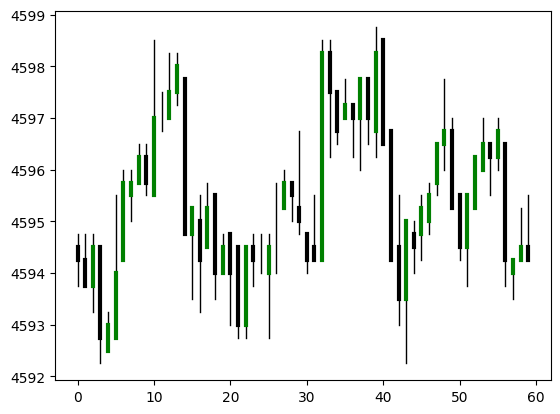

In [7]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
plot_candles(list(m.m1_candles))


In [43]:

tf.function(jit_compile=False) # my gpu does not support this
def tstep(data):
    x, y = data

    with tf.GradientTape() as t:
        model_return = model(x, training=True)
        #print(y, model_return)
        loss = tf.math.square(y - model_return)
        #print(loss)
        loss = tf.reduce_mean(loss)


    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss


# In[14]:

batch_size = 256

train_index = 0
def get_data(_):
    global train_index
    train_sample = [train_data[i] for i in range(train_index, train_index + batch_size)]
    train_index += batch_size
    if train_index + batch_size >= len(train_data):
        train_index = 0

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = np.array([x[1] for x in train_sample], dtype="float32")
    targets_tensor = tf.convert_to_tensor(targets)

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)


In [ ]:
@tf.function
def run(data):
    loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, strategy.run(tstep, args = (data,)), axis = None)
    return loss


losses = []
for _ in tqdm(range(1000)):
    distributed_data = (strategy.experimental_distribute_values_from_function(get_data))
    loss = run(distributed_data)
    #print(loss)
    losses.append(loss)

plt.plot(losses)

 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [00:26<00:06, 33.01it/s]

In [ ]:
model.save_weights("model.weights.h5")
